Author: Onyedikachukwu Okonkwo
Project: Lloyd Bank EDA Project

In [28]:
# install libraries
!python -m pip install --upgrade pip -q
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl -q
!pip install notebook -q
!pip install nbconvert -q
!pip install tabulate -q


# Lloyd Bank EDA

## Bottom Line Up Front

- Discovered through clustering that our **Most** valuable customers in Group 6 and 8 churn with a Churn Rate at rates higher than average. 
- Group 6 spend 0.44 above average but churn at 0.21
- Group 8 spend 0.36 above average but churn at 0.27
- They are our most valuable customers and we cannot figure out why they are leaving, because the features we rely on have such poor correlation a coin flip is better at predicting churn. 
- The group with the lowest churn is our **Least** Valuable customers. They spend the least.

- The data is all over the place, and no single feature seems to correlate to the why they churn at such a high clip.  Further analysis is required. 




### Project Overview

***Objective:*** First Critical Steps to build a predictive model for customer churn.  Gather all relevant data, and then conduct an EDA and prepare the data set for model development. 
Key Results:


***Business Problem:*** 
We need to predict which of our customers are likely to churn. 

**Goal:** 
Conduct exploratory data analysis and translate findings into a predictive model that can predict which customers are going to churn. 
Methodology and Justification.

**Tools Used:**
Python for data cleaning, manipulation, analysis, and visualization
Reason: Python has libraries that are suited for the assignment. Pandas is used to manipulate the data, numpy for calculation, matplotlib and seaborn for data visualization, sklearn for machine learning model, and datetime to calculate date ranges in days. 


In [29]:

#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### Identify and Gathering Steps:
-	Downloaded the data from the excel files, and the uploaded a copy using pd.read_excel as it is an excel file.
-	Kept the names the same as the sheets for consistency across the board. 
-	Printed the head of each Sheet and compared to original dataset for accuracy and to ensure consistency and nothing is lost


In [30]:
# Set Display Options
pd.set_option('display.max_columns', None) # Set option to display all columns
pd.set_option('display.float_format', '{:.2f}'.format) # Set float format to 2 decimal places

Churn_Status = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Churn_Status')
Customer_Demographics = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Demographics')
Transaction_History = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Transaction_History')
Customer_Service = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Service')
Online_Activity = pd.read_excel('Customer_Churn_Data_Large.xlsx', sheet_name='Online_Activity')



In [31]:
# Display first few rows of each dataset
print("Churn Status:")
print(Churn_Status.head()) 
print("\nCustomer Demographics:")
print(Customer_Demographics.head())
print("\nTransaction History:")
print(Transaction_History.head())
print("\nCustomer Service:")        
print(Customer_Service.head())
print("\nOnline Activity:")
print(Online_Activity.head())

# Display info of each dataset to understand structure and data types
print(Customer_Demographics.info())
print(Transaction_History.info())
print(Churn_Status.info())
print(Customer_Service.info())
print(Online_Activity.info())

Churn Status:
   CustomerID  ChurnStatus
0           1            0
1           2            1
2           3            0
3           4            0
4           5            0

Customer Demographics:
   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium

Transaction History:
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing

Customer Service:
   

### Data Cleaning Process

-   Created a backup of the original raw data
-	Created a Transaction_Summary based on Transaction_History grouped by CustomerID to create a single column per customer rather than multiple columns.
-	Grouped by minimum and Maximum transaction, the amount of transactions, and the total spent per customers, also calculated the LoyaltyLength by subtracting the most recent transaction date by the first transaction date. 

All these are new columns that are added to a table and dropped all null values from Transaction_Summary I don’t need to analyze customers who haven’t spend any money. 

***Documentation:*** All cleaning steps are documented with inline comments.
-	For the Customer_Service, and InteractionType, I created unique columns again to make sure there is one column per CustomerID as it has a one to many relationship with InteractionType. 1 customer can put in multiple Interaction or have none,  The summary dataframe groups it by feedback, inquiry or complaint and if it was resolved or not each has its own columns assigned to that customer. 
-	For customers with no values the Nan are filled with 0 rather than dropping the column
-	For customer with no demographics or churn status or online activity, they Nan Values were dropped. 
-	The result was we started with 1000 rows and ended up with 1000 rows. 
-	Customer_Data is a new table that groups all these tables and columns together using a merge and inner join for the Churn_Status and the Demographics on the CustomerID because they are the key place holders. Then a left join with Transaction_Summary, Customer_Service_Summary, and the Online_Activity.
-	Consolidated all the data into Customer_Data and encoded the non_numeric columns to prepare for learning model. 

***Data Quality Assessment (ROCCC):***
- Reliable: Direct from mock company data
- Original: First-party company data
- Comprehensive: Contains all necessary variables for analysis
- Current: Static dataset (not real-time)
- Cited:  Well-documented source

***Limitations:***
- Data does not indicate if feedback is positive or negative which is a valid metric in measuring which customers churn. 
- Data is not dynamic/real-time
- Limited to a point-in-time snapshot



In [32]:
# Create New Columns based on Transaction History of each "CustomerID"
Transaction_Summary = Transaction_History.groupby('CustomerID').agg(
    TotalSpent = ("AmountSpent", "sum"), # Create column for total transaction amount
    MinTransaction = ("AmountSpent", "min"), # Create column for minimum transaction amount
    MaxTransaction = ("AmountSpent", "max"), # Create column for maximum transaction amount
    TransactionFrequency = ("AmountSpent", "count"), # Create column for frequency of transactions
    MostRecentTransaction = ("TransactionDate", "max"), # Create column for most recent transaction date
    FirstTransaction = ("TransactionDate", "min") # Create column for first transaction date
).reset_index()

# Create column for length of relationship based on first transaction and most recent transaction
Transaction_Summary['LoyaltyLength'] = (Transaction_Summary['MostRecentTransaction'] - Transaction_Summary['FirstTransaction']).dt.days
Transaction_Summary = Transaction_Summary.fillna(0)  # Fill any NaN values with 0

In [33]:
# Check to make sure all is right with the cosmos thus far
display(Transaction_Summary.head())

,CustomerID,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,MostRecentTransaction,FirstTransaction,LoyaltyLength
0,1,416.50,416.50,416.50,1,2022-03-27,2022-03-27,0
1,2,1547.42,54.96,397.37,7,2022-11-19,2022-01-09,314
2,3,1702.98,51.07,419.95,6,2022-10-08,2022-02-11,239
3,4,917.29,44.22,382.39,5,2022-12-27,2022-05-22,219
4,5,2001.49,69.86,475.69,8,2022-12-21,2022-02-21,303


In [34]:
Interaction_Types = Customer_Service['InteractionType'].unique() # Make a List of the different interaction types

summaries = [] # Create an empty list to hold the summaries of each interaction type

for interaction_type in Interaction_Types: # for loop that loops through each interaction type and creates a summary dataframe
    type_summary = Customer_Service[Customer_Service['InteractionType'] == interaction_type].groupby('CustomerID').agg(**{ # group by CustomerID and aggregate the data
        f"{interaction_type}Count": ('InteractionType', 'count'), # f string to create dynamic column names
        f"{interaction_type}Resolved": ("ResolutionStatus", lambda x: (x == 'Resolved').sum())
    }).reset_index()
    
    type_summary[f"{interaction_type}Unresolved"] = type_summary[f"{interaction_type}Count"] - type_summary[f"{interaction_type}Resolved"] # since we cant add or subtract in the agg function, we create a new column for unresolved interactions by subtracting resolved from total count
    
    summaries.append(type_summary) # append the summary dataframe to the list
    
# Merge all interaction summaries into a single dataframe
Customer_Service_Summary = summaries[0] # start with the first summary
for i in range(1, len(summaries)): # loop through the rest of the summaries
    Customer_Service_Summary = pd.merge(Customer_Service_Summary, summaries[i], on='CustomerID', how='outer') # merge on CustomerID with an outer join to keep all customers

#fill NaN values with 0s for customers who did not have certain interaction types
Customer_Service_Summary = Customer_Service_Summary.fillna(0)
# Check to make sure all is right with the cosmos thus far
display(Customer_Service_Summary.head())

,CustomerID,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved
0,1,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,6,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00


In [35]:
# Address Nan values in individual datasets before merging
Customer_Demographics = Customer_Demographics.dropna()
Churn_Status = Churn_Status.dropna()
Online_Activity = Online_Activity.dropna()

#  Merge Customer Demographics, Transaction Summary, Customer Service Summary, Online Activity, and Churn Status into a single dataframe
Customer_Data = pd.merge(Customer_Demographics, Churn_Status, on='CustomerID', how = 'inner')
Customer_Data = pd.merge(Customer_Data, Transaction_Summary, on='CustomerID', how = 'left').fillna(0) # Fill NaN values with 0 for customers with no transactions
Customer_Data = pd.merge(Customer_Data, Customer_Service_Summary, on='CustomerID', how = 'left').fillna(0) # Fill NaN values with 0 for customers with no customer service interactions
Customer_Data = pd.merge(Customer_Data, Online_Activity, on='CustomerID', how = 'left')


### Analysis Steps:
1.	***Descriptive Statistics***
-	Used the  describe().T function to calculate mean, median, standard deviation, minimum, 25% quartile, median 75% quartile, maximum, and then the skew and kurtosis as well for all numeric variables. 
-	Calculated skew and kurtosis to determine distribution shapes, and see where the outliers mostly are, and to determine where to use StandardScale or RobustScale when calculating z scores.
-	Calculated the churn_rate to check for balance.  

2.	***Relationship Analysis***
- Correlation analysis between variables and churn_rate.
-Visualization with bar graph and box plots to confirm correlation calculations, check for outliers and confirm statistical information.



In [36]:

#Create a table to summarize numerical features
description = Customer_Data.select_dtypes(include='number').describe().T
description['skew'] = Customer_Data.select_dtypes(include='number').skew()
description['kurtosis'] = Customer_Data.select_dtypes(include='number').kurtosis()
description.round(2)

# Final check to make sure all is right with the cosmos thus far
print(Customer_Data.info())
display(Customer_Data.head())
display(description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CustomerID             1000 non-null   int64         
 1   Age                    1000 non-null   int64         
 2   Gender                 1000 non-null   object        
 3   MaritalStatus          1000 non-null   object        
 4   IncomeLevel            1000 non-null   object        
 5   ChurnStatus            1000 non-null   int64         
 6   TotalSpent             1000 non-null   float64       
 7   MinTransaction         1000 non-null   float64       
 8   MaxTransaction         1000 non-null   float64       
 9   TransactionFrequency   1000 non-null   int64         
 10  MostRecentTransaction  1000 non-null   datetime64[ns]
 11  FirstTransaction       1000 non-null   datetime64[ns]
 12  LoyaltyLength          1000 non-null   int64         
 13  Inqu

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,ChurnStatus,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,MostRecentTransaction,FirstTransaction,LoyaltyLength,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved,LastLoginDate,LoginFrequency,ServiceUsage
0,1,62,M,Single,Low,0,416.50,416.50,416.50,1,2022-03-27,2022-03-27,0,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-10-21,34,Mobile App
1,2,65,M,Married,Low,1,1547.42,54.96,397.37,7,2022-11-19,2022-01-09,314,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-12-05,5,Website
2,3,18,M,Single,Low,0,1702.98,51.07,419.95,6,2022-10-08,2022-02-11,239,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-11-15,3,Website
3,4,21,M,Widowed,Low,0,917.29,44.22,382.39,5,2022-12-27,2022-05-22,219,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-25,2,Website
4,5,21,M,Divorced,Medium,0,2001.49,69.86,475.69,8,2022-12-21,2022-02-21,303,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-10-27,41,Website


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
CustomerID,1000.00,500.50,288.82,1.00,250.75,500.50,750.25,1000.00,0.00,-1.20
Age,1000.00,43.27,15.24,18.00,30.00,43.00,56.00,69.00,0.01,-1.21
ChurnStatus,1000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00,1.47,0.17
TotalSpent,1000.00,1267.07,738.59,9.80,626.68,1232.88,1791.90,3386.04,0.27,-0.79
MinTransaction,1000.00,107.07,101.08,5.18,32.80,74.62,146.40,496.99,1.60,2.39
MaxTransaction,1000.00,390.18,107.38,9.80,342.86,429.93,468.50,499.86,-1.51,1.90
TransactionFrequency,1000.00,5.05,2.60,1.00,3.00,5.00,7.00,9.00,-0.06,-1.24
LoyaltyLength,1000.00,208.11,109.96,0.00,137.75,240.00,294.25,361.00,-0.73,-0.70
InquiryCount,1000.00,0.31,0.52,0.00,0.00,0.00,1.00,2.00,1.43,1.09
InquiryResolved,1000.00,0.17,0.40,0.00,0.00,0.00,0.00,2.00,2.20,4.01


In [37]:
# Count how many customers churned vs. did not churn
churn_counts = Customer_Data['ChurnStatus'].value_counts()
print(churn_counts)
# Calculate churn rate
churn_rate = (churn_counts[1] / churn_counts.sum()) * 100  # Percentage of customers who churned
print(f"Churn Rate: {churn_rate:.2f}%") 

ChurnStatus
0    796
1    204
Name: count, dtype: int64
Churn Rate: 20.40%


Gender
F   0.20
M   0.21
Name: ChurnStatus, dtype: float64


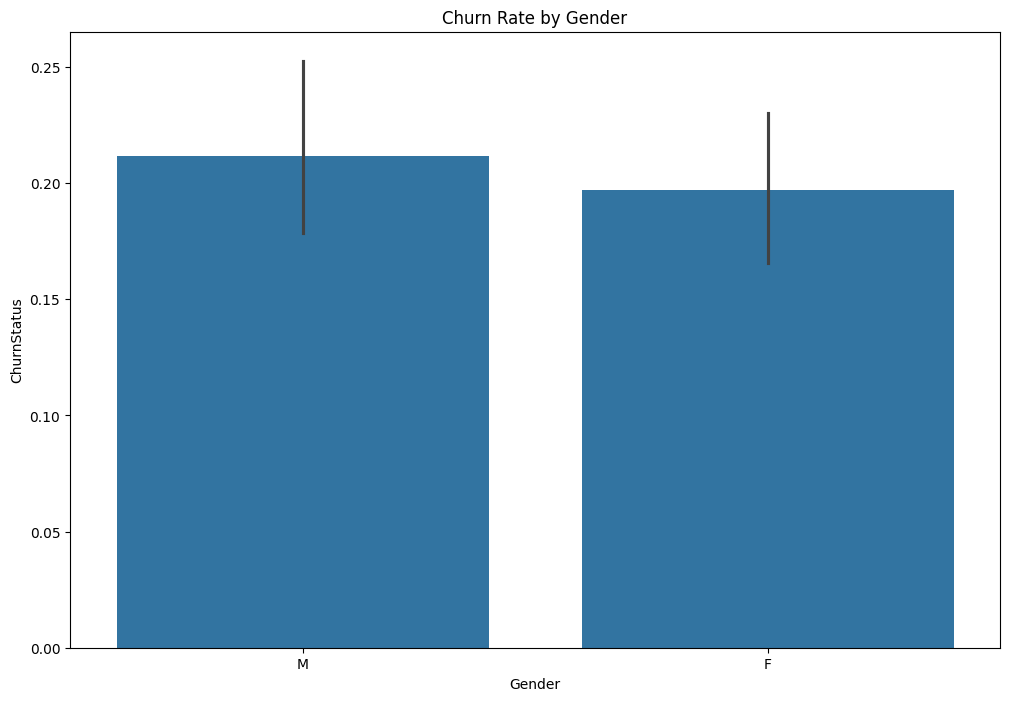

MaritalStatus
Divorced   0.19
Married    0.23
Single     0.20
Widowed    0.20
Name: ChurnStatus, dtype: float64


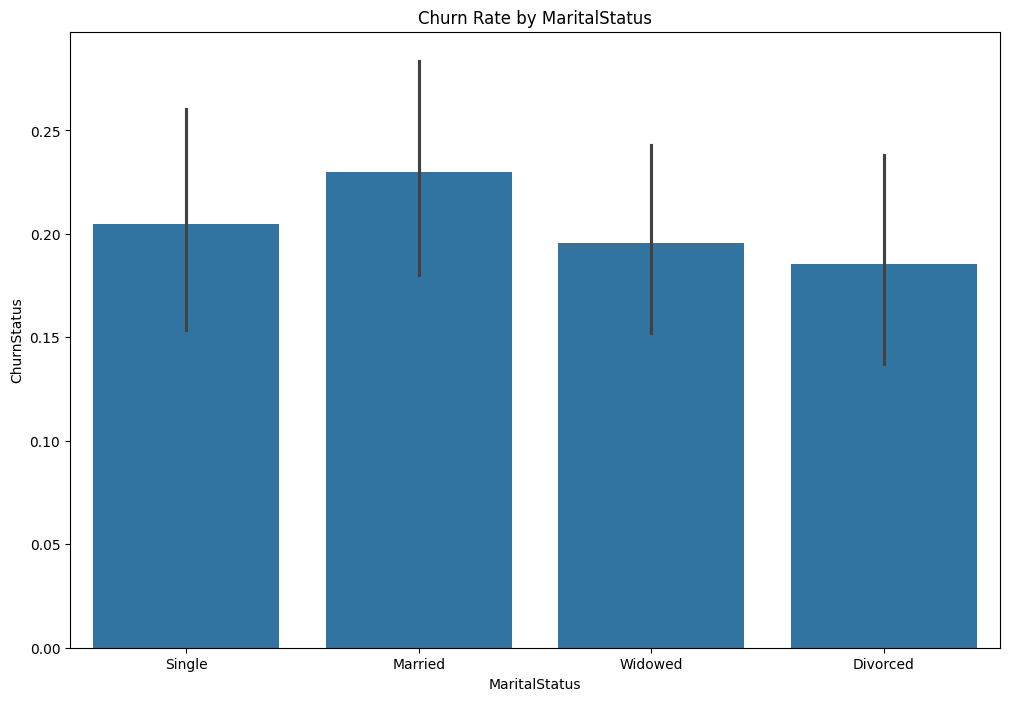

IncomeLevel
High     0.19
Low      0.22
Medium   0.20
Name: ChurnStatus, dtype: float64


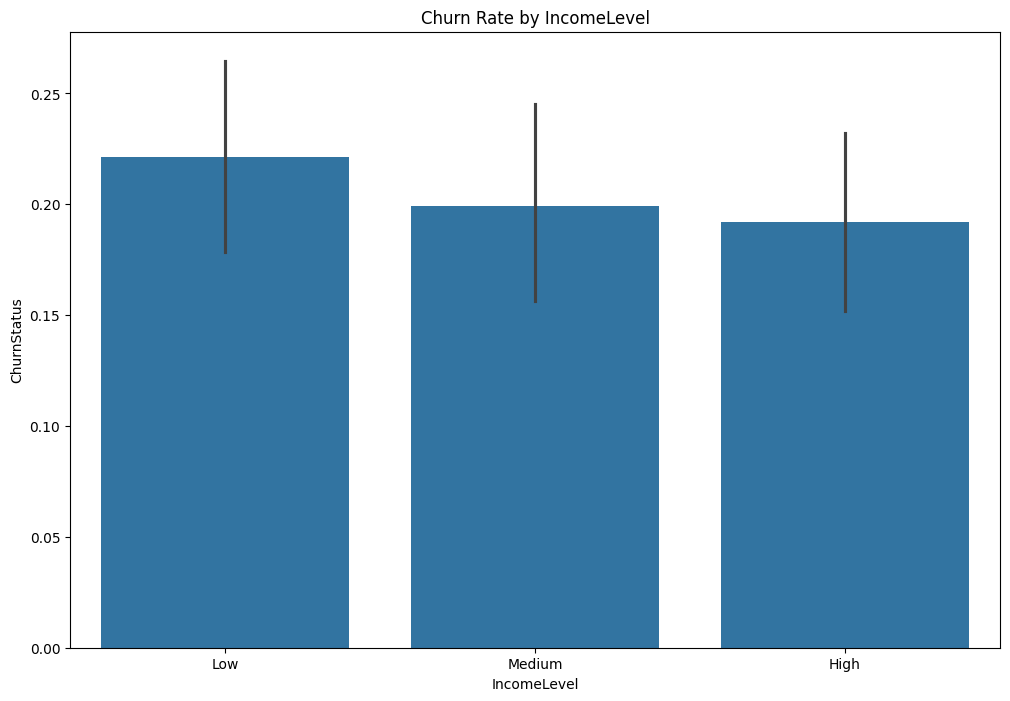

ServiceUsage
Mobile App       0.23
Online Banking   0.20
Website          0.18
Name: ChurnStatus, dtype: float64


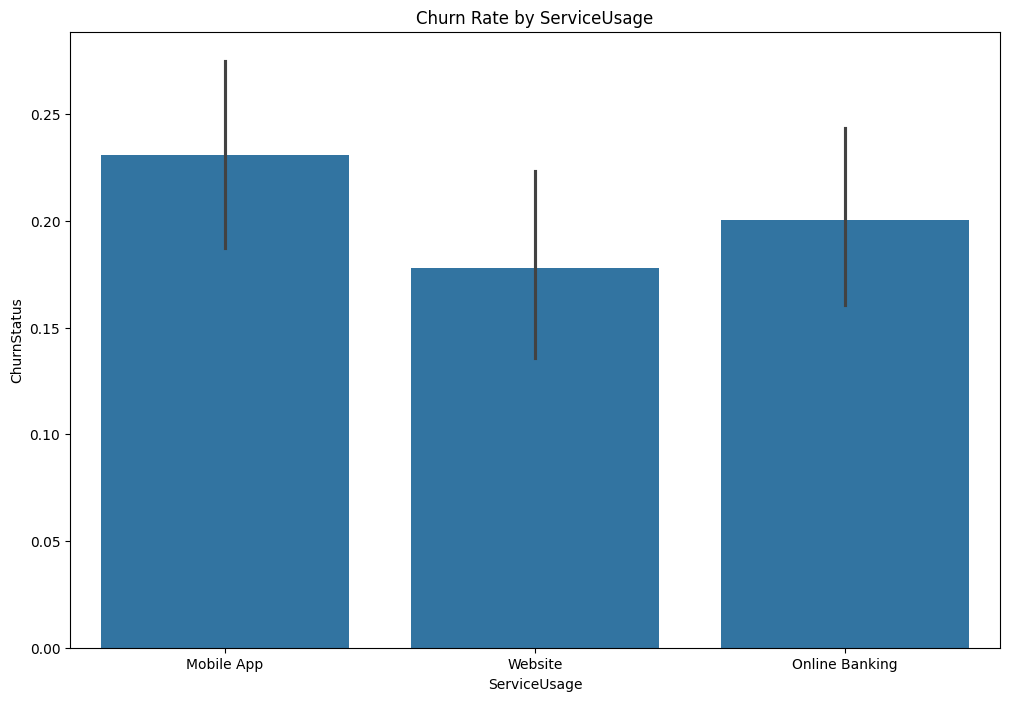

In [38]:
# For Loop to calculate churn rates for categorical variables
categorical_columns = Customer_Data.select_dtypes(include='object').columns

for col in categorical_columns:
    churn_rates = Customer_Data.groupby(col)['ChurnStatus'].mean()
    print(churn_rates)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=col, y='ChurnStatus', data=Customer_Data)
    plt.title(f'Churn Rate by {col}')
    plt.show()


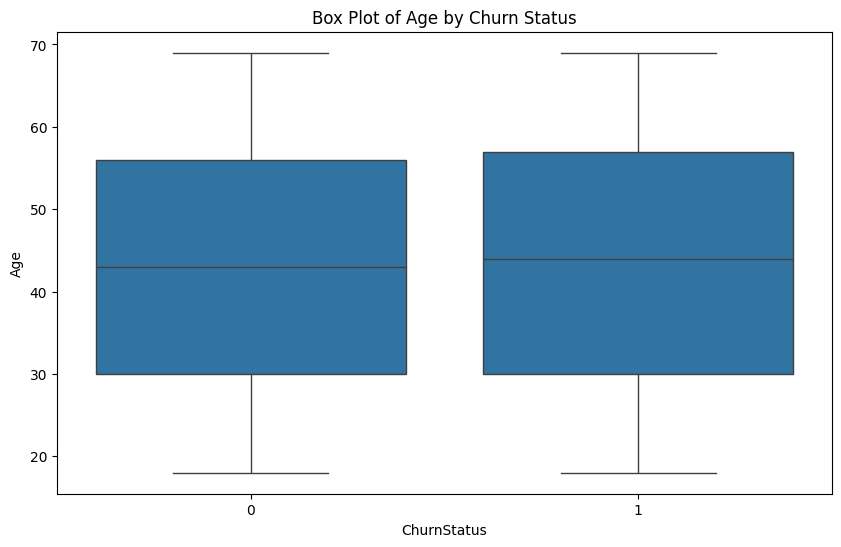

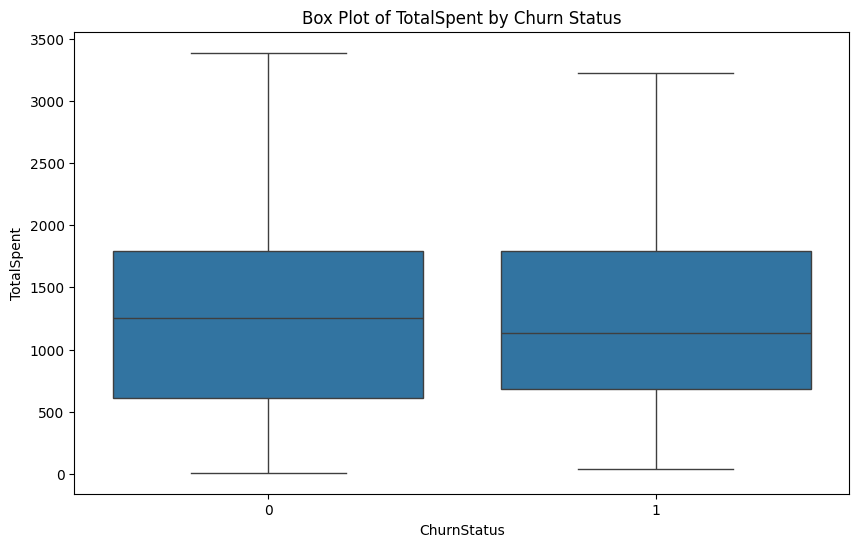

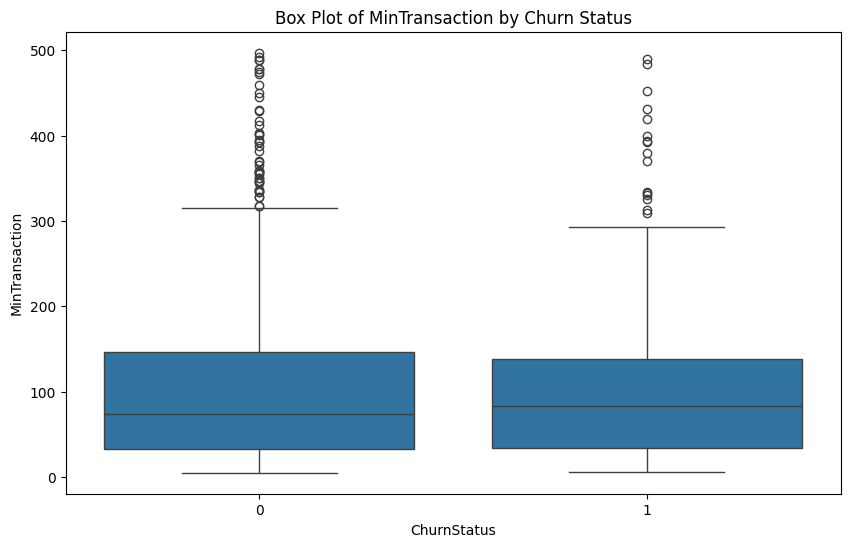

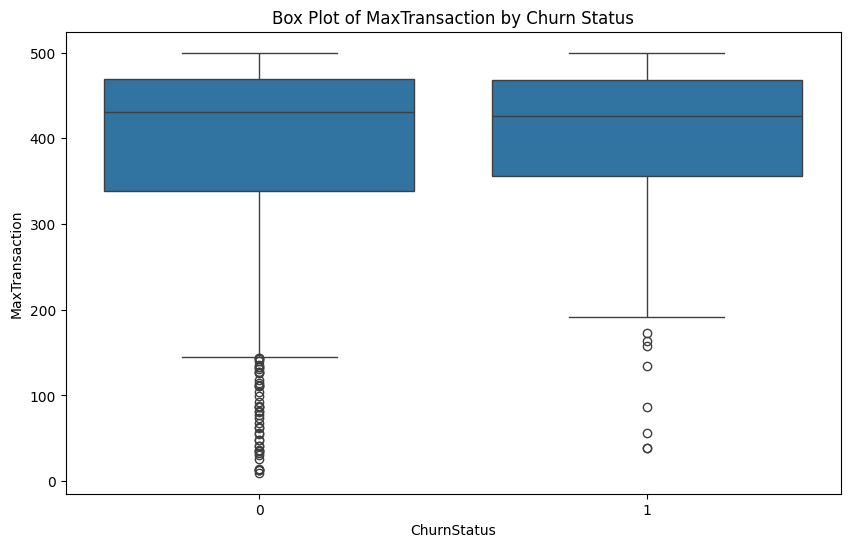

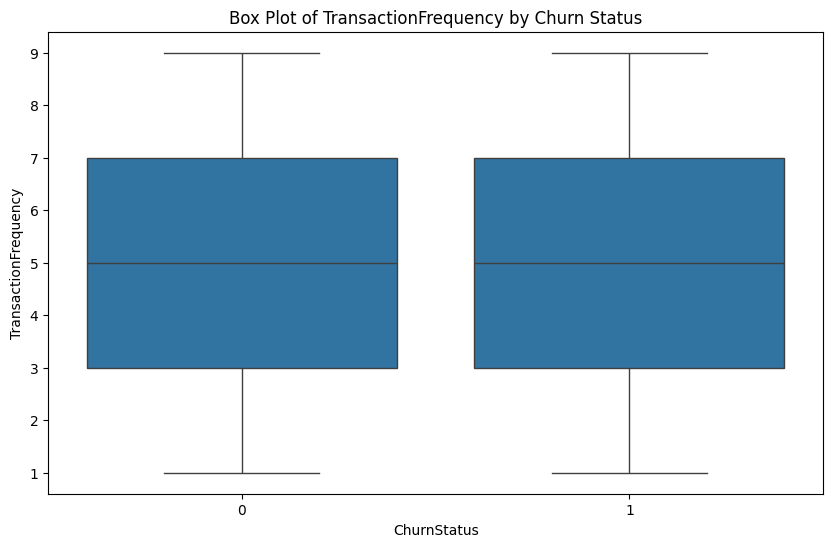

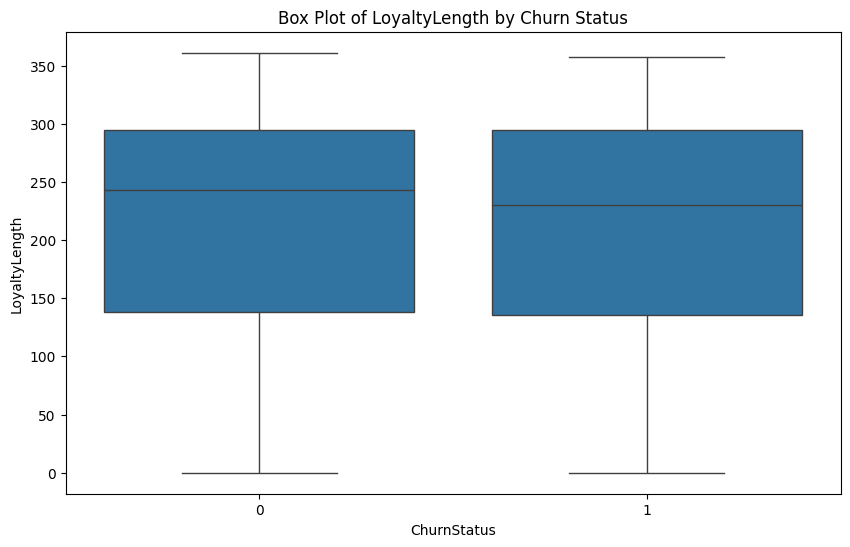

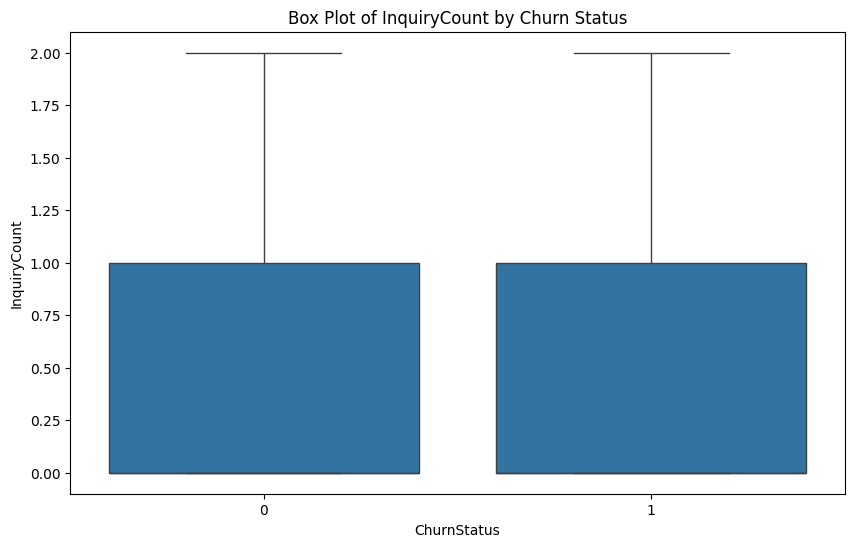

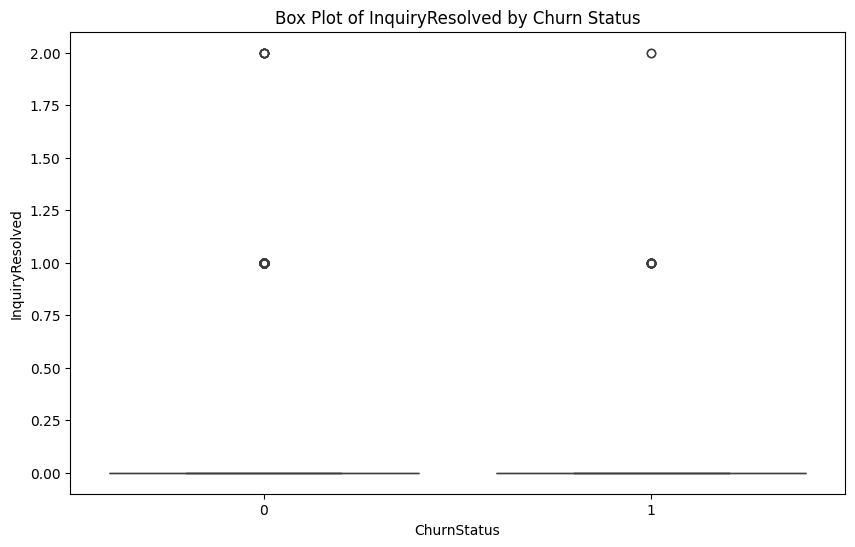

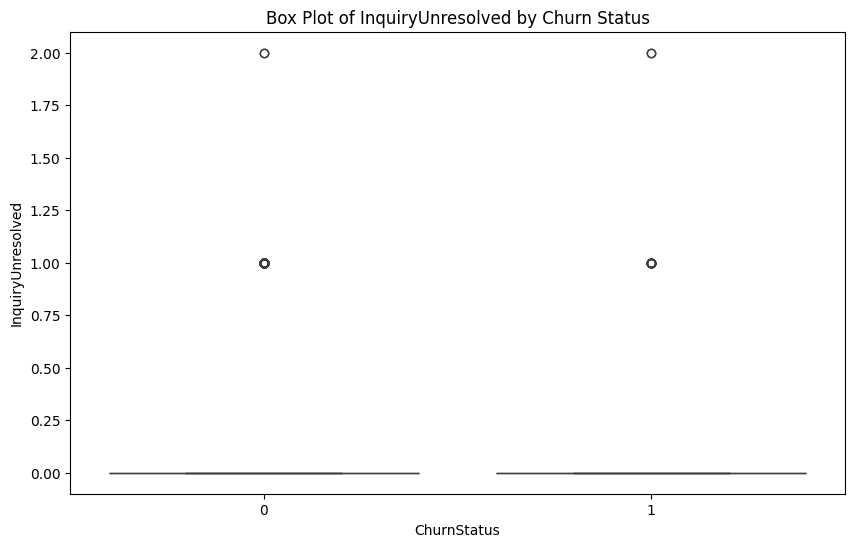

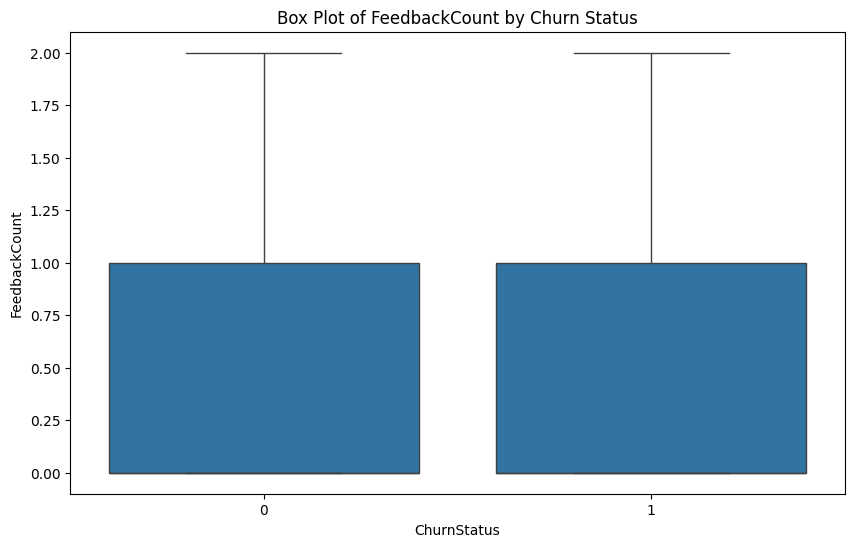

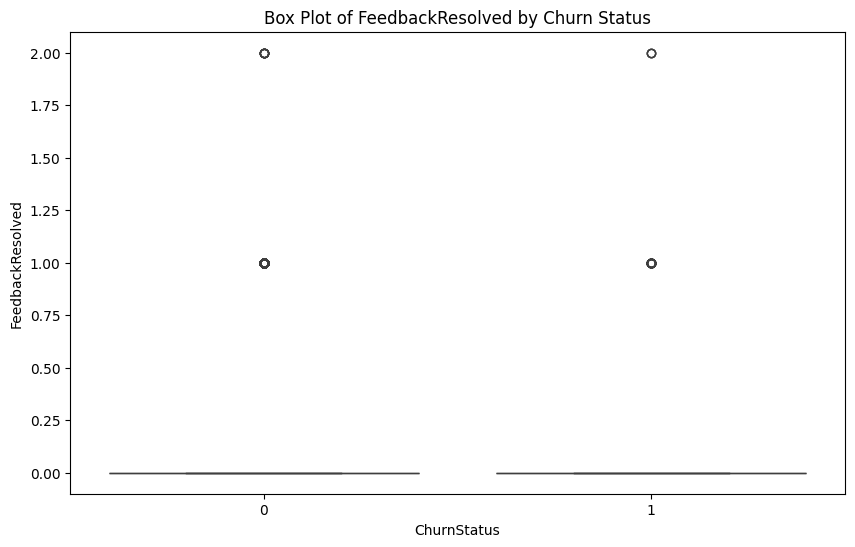

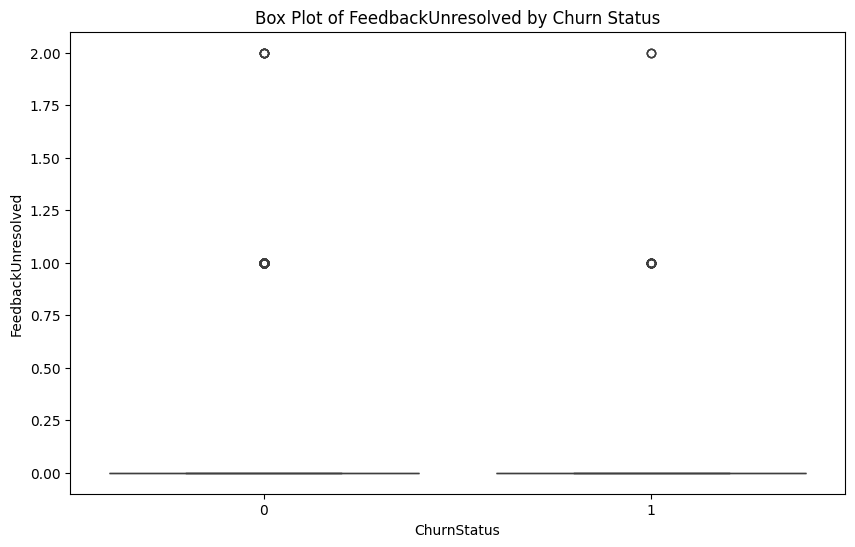

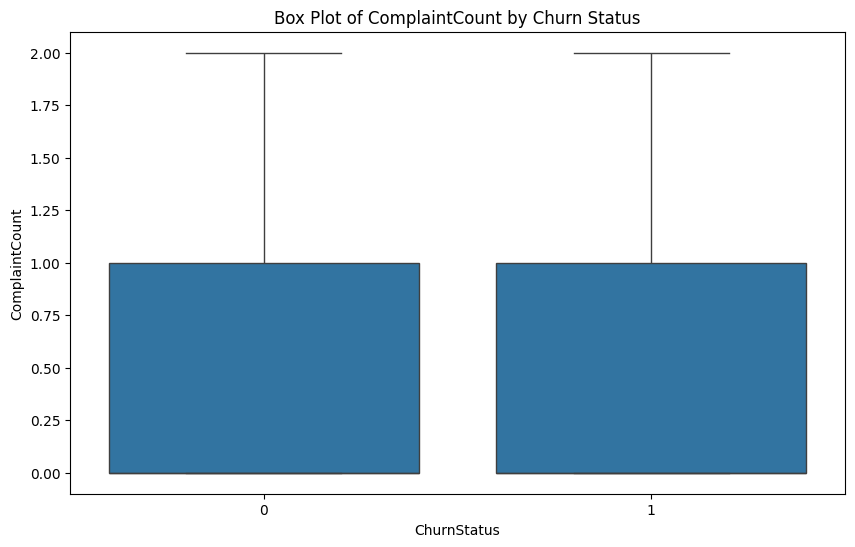

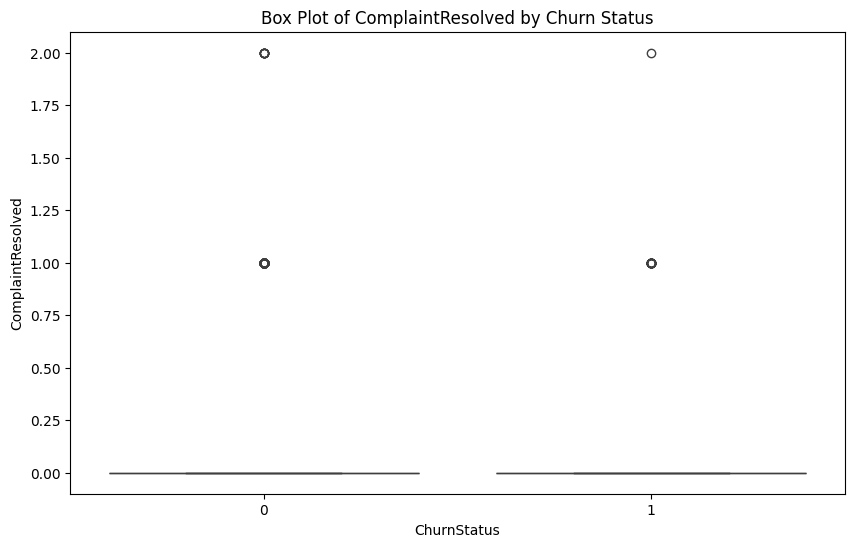

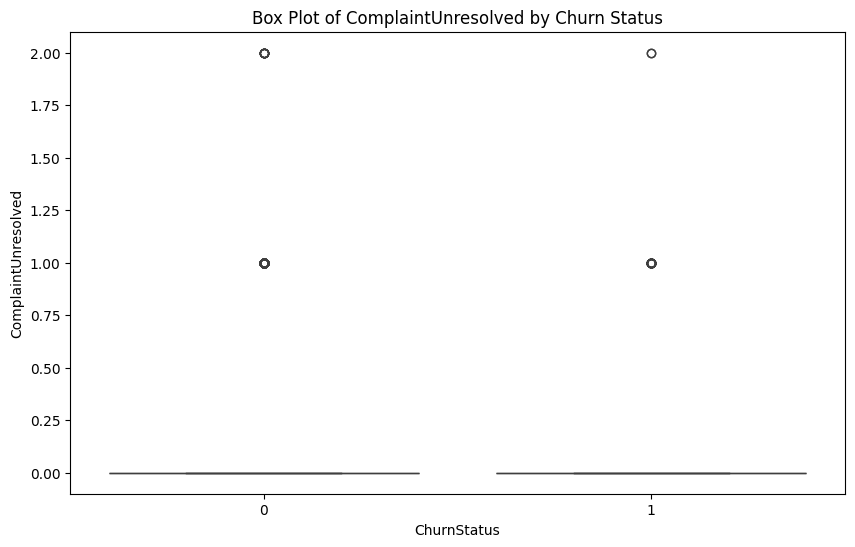

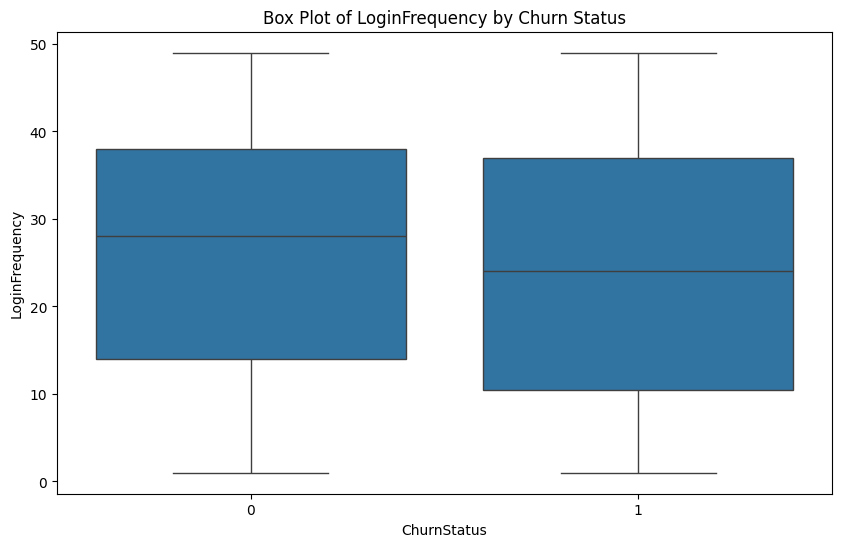

In [39]:
# For Loop to plot box plots for the numerical variables against churn status
numerical_columns = Customer_Data.select_dtypes(include='number').columns.drop(['ChurnStatus','CustomerID'])
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ChurnStatus', y=col, data=Customer_Data)
    plt.title(f'Box Plot of {col} by Churn Status')
    plt.show()    

Encode categorical data to numbers to prep for algorithm

In [40]:
# Encode categorical variables using mapping for the IncomeLevel as order matters. 

Customer_Data['IncomeLevel'] = Customer_Data['IncomeLevel'].map({
    'Low': 1,
    'Medium': 2,
    'High': 3
    })

display(Customer_Data.head())

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,ChurnStatus,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,MostRecentTransaction,FirstTransaction,LoyaltyLength,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved,LastLoginDate,LoginFrequency,ServiceUsage
0,1,62,M,Single,1,0,416.50,416.50,416.50,1,2022-03-27,2022-03-27,0,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-10-21,34,Mobile App
1,2,65,M,Married,1,1,1547.42,54.96,397.37,7,2022-11-19,2022-01-09,314,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-12-05,5,Website
2,3,18,M,Single,1,0,1702.98,51.07,419.95,6,2022-10-08,2022-02-11,239,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-11-15,3,Website
3,4,21,M,Widowed,1,0,917.29,44.22,382.39,5,2022-12-27,2022-05-22,219,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-25,2,Website
4,5,21,M,Divorced,2,0,2001.49,69.86,475.69,8,2022-12-21,2022-02-21,303,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-10-27,41,Website


In [41]:
# Encode Gender using one-hot encoding since order does not matter

isMale = pd.get_dummies(Customer_Data['Gender'], drop_first=True)
Customer_Data['Gender'] = isMale
Customer_Data['Gender'] = Customer_Data['Gender'].astype(int) # Change from true to an integer 1

# Rename Columns for clarity
Customer_Data = Customer_Data.rename(columns={'Gender': 'isMale'})

# Drop the date columns as they have served their purpose
Customer_Data = Customer_Data.drop(columns=['MostRecentTransaction', 'FirstTransaction', 'LastLoginDate'])


In [42]:
display(Customer_Data.head())

,CustomerID,Age,isMale,MaritalStatus,IncomeLevel,ChurnStatus,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,LoyaltyLength,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved,LoginFrequency,ServiceUsage
0,1,62,1,Single,1,0,416.50,416.50,416.50,1,0,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34,Mobile App
1,2,65,1,Married,1,1,1547.42,54.96,397.37,7,314,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,Website
2,3,18,1,Single,1,0,1702.98,51.07,419.95,6,239,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,Website
3,4,21,1,Widowed,1,0,917.29,44.22,382.39,5,219,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2,Website
4,5,21,1,Divorced,2,0,2001.49,69.86,475.69,8,303,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41,Website


In [43]:
# Encode all the other categorical variables using one-hot encoding
Customer_Data = pd.get_dummies(Customer_Data, columns=['MaritalStatus', 'ServiceUsage'], dtype=int)
display(Customer_Data.head())
Customer_Data.info()

,CustomerID,Age,isMale,IncomeLevel,ChurnStatus,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,LoyaltyLength,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved,LoginFrequency,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,ServiceUsage_Mobile App,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,62,1,1,0,416.50,416.50,416.50,1,0,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34,0,0,1,0,1,0,0
1,2,65,1,1,1,1547.42,54.96,397.37,7,314,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,0,1,0,0,0,0,1
2,3,18,1,1,0,1702.98,51.07,419.95,6,239,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,0,0,1,0,0,0,1
3,4,21,1,1,0,917.29,44.22,382.39,5,219,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2,0,0,0,1,0,0,1
4,5,21,1,2,0,2001.49,69.86,475.69,8,303,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41,1,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   1000 non-null   int64  
 1   Age                          1000 non-null   int64  
 2   isMale                       1000 non-null   int64  
 3   IncomeLevel                  1000 non-null   int64  
 4   ChurnStatus                  1000 non-null   int64  
 5   TotalSpent                   1000 non-null   float64
 6   MinTransaction               1000 non-null   float64
 7   MaxTransaction               1000 non-null   float64
 8   TransactionFrequency         1000 non-null   int64  
 9   LoyaltyLength                1000 non-null   int64  
 10  InquiryCount                 1000 non-null   float64
 11  InquiryResolved              1000 non-null   float64
 12  InquiryUnresolved            1000 non-null   float64
 13  FeedbackCount      

In [44]:

# Export to excel for submission

Customer_Data.to_excel('Customer_Data_Cleaned.xlsx', index=False)


In [45]:
# Used StandardScaler() to calculate z scores so all numeric values hold the same weight. 
from sklearn.preprocessing import StandardScaler

# Identify columns to scale drop non-numeric and target variable as well as CustomerID
columns_to_scale = Customer_Data.select_dtypes(include='number').columns.drop(['CustomerID', 'ChurnStatus'])

# Scale them
scaler = StandardScaler()
scaled_values = scaler.fit_transform(Customer_Data[columns_to_scale])
Customer_Data[columns_to_scale] = scaler.fit_transform(Customer_Data[columns_to_scale])

display(Customer_Data.head())

,CustomerID,Age,isMale,IncomeLevel,ChurnStatus,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,LoyaltyLength,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved,LoginFrequency,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,ServiceUsage_Mobile App,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,1.23,1.03,-1.25,0,-1.15,3.06,0.25,-1.56,-1.89,1.34,2.09,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,0.58,-0.57,-0.59,1.91,-0.62,1.39,-0.73,-0.67
1,2,1.43,1.03,-1.25,1,0.38,-0.52,0.07,0.75,0.96,1.34,2.09,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,-1.49,-0.57,1.68,-0.52,-0.62,-0.72,-0.73,1.50
2,3,-1.66,1.03,-1.25,0,0.59,-0.55,0.28,0.36,0.28,1.34,2.09,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,-1.63,-0.57,-0.59,1.91,-0.62,-0.72,-0.73,1.50
3,4,-1.46,1.03,-1.25,0,-0.47,-0.62,-0.07,-0.02,0.10,3.27,2.09,2.41,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,-1.70,-0.57,-0.59,-0.52,1.62,-0.72,-0.73,1.50
4,5,-1.46,1.03,-0.03,0,0.99,-0.37,0.80,1.13,0.86,-0.59,-0.42,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,1.07,1.74,-0.59,-0.52,-0.62,-0.72,-0.73,1.50


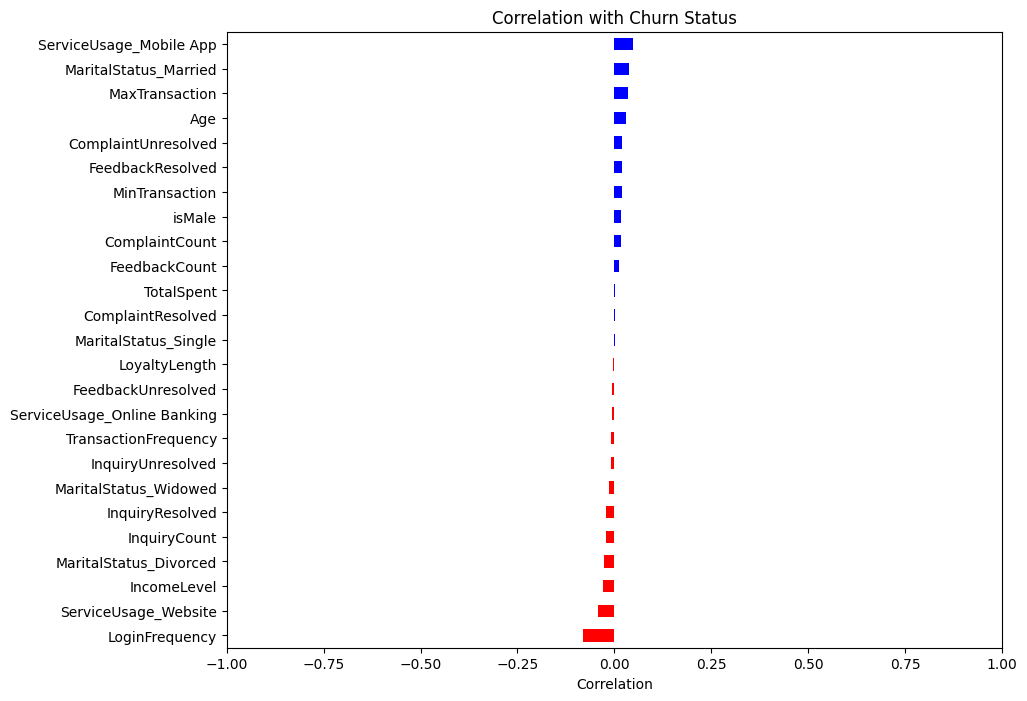

In [46]:
# Check Correlation of numerical features with Churn Status

churn_corr = Customer_Data.select_dtypes(include='number').corr()['ChurnStatus'].drop(['ChurnStatus', 'CustomerID']).sort_values() # include all numerical values -ChurnStatus and CustoomeID

plt.figure(figsize=(10, 8))
churn_corr.plot(kind='barh', color=['red' if x < 0 else 'blue' for x in churn_corr]) # a horizontal bar plot with red for negative correlation and blue for positive correlation
plt.title('Correlation with Churn Status')
plt.xlabel('Correlation')
plt.xlim(-1, 1)
plt.show()

***Observation:***

There is little to no correlation with any of the features to ChurnStatus the strongest correlation is LoginFrequency at approximately 0.08. It might as well be nothing. 

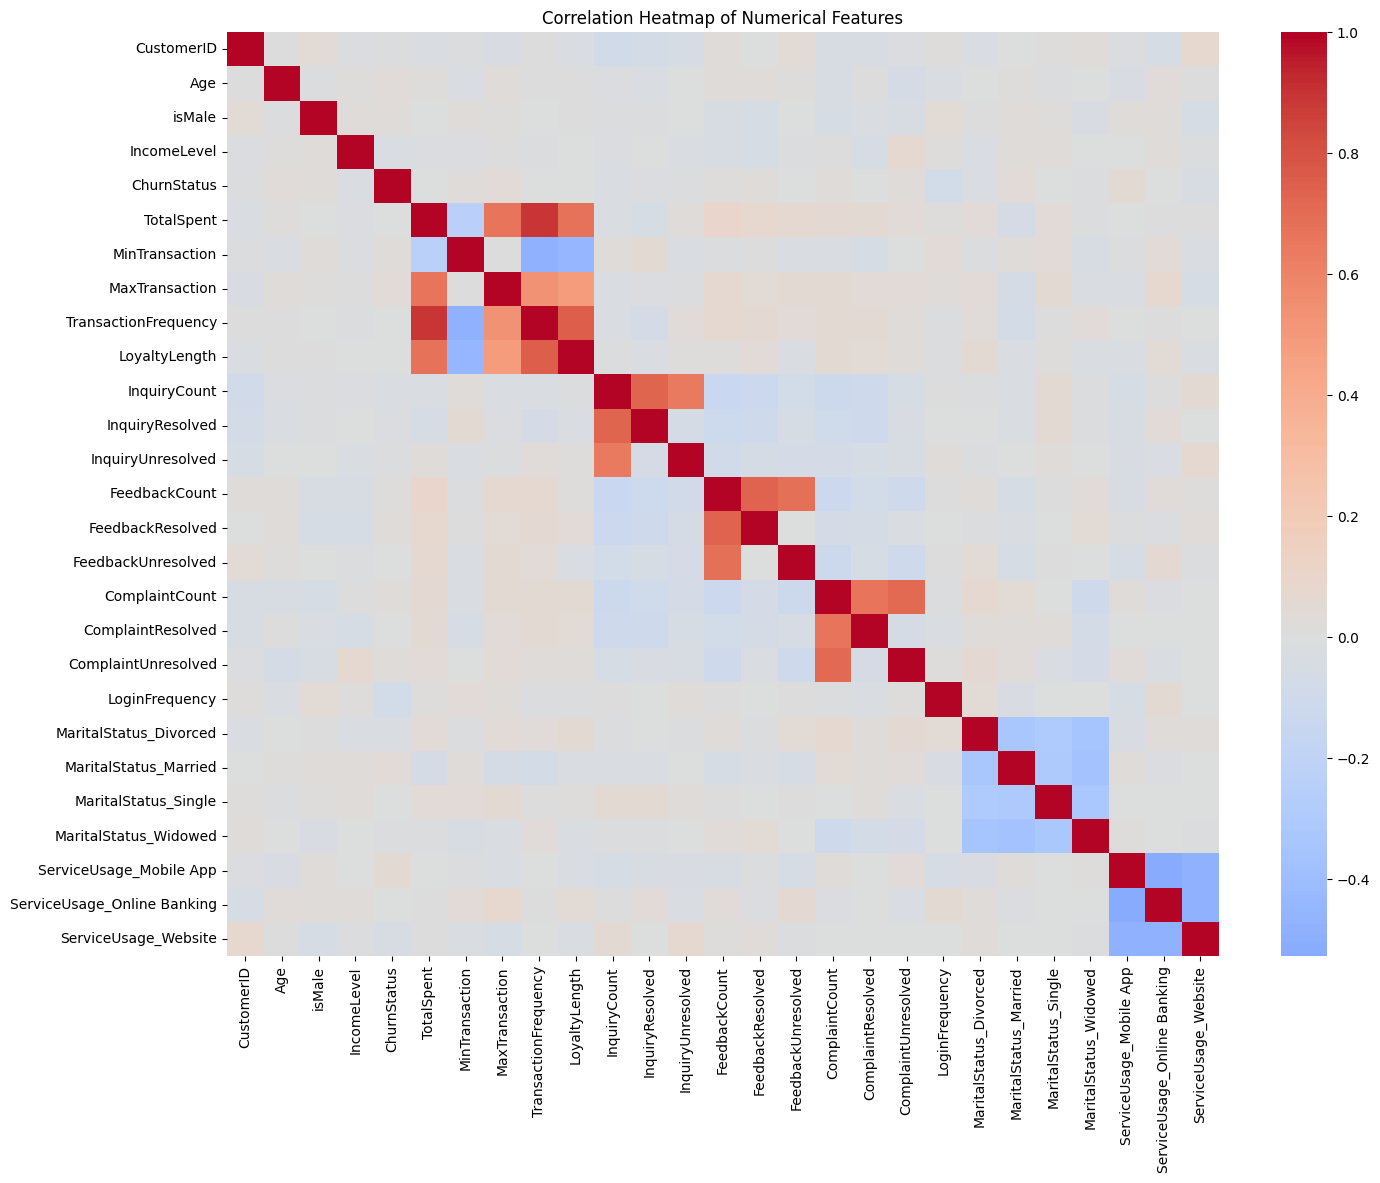

In [47]:
# do a correlation heatmap to see how features correlate with each other
plt.figure(figsize=(16, 12))
correlation_matrix = Customer_Data.select_dtypes(include='number').corr() # select only numerical columns
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

***Observation***

There is little to no correlation with any of the features with each other. 

***Why It Matters:***
This indicates a systemic issue with data collection that must be addressed. The data we collect is next to useless for driving any meaningful business decision.  

In [48]:
display(Customer_Data.head())

,CustomerID,Age,isMale,IncomeLevel,ChurnStatus,TotalSpent,MinTransaction,MaxTransaction,TransactionFrequency,LoyaltyLength,InquiryCount,InquiryResolved,InquiryUnresolved,FeedbackCount,FeedbackResolved,FeedbackUnresolved,ComplaintCount,ComplaintResolved,ComplaintUnresolved,LoginFrequency,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,ServiceUsage_Mobile App,ServiceUsage_Online Banking,ServiceUsage_Website
0,1,1.23,1.03,-1.25,0,-1.15,3.06,0.25,-1.56,-1.89,1.34,2.09,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,0.58,-0.57,-0.59,1.91,-0.62,1.39,-0.73,-0.67
1,2,1.43,1.03,-1.25,1,0.38,-0.52,0.07,0.75,0.96,1.34,2.09,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,-1.49,-0.57,1.68,-0.52,-0.62,-0.72,-0.73,1.50
2,3,-1.66,1.03,-1.25,0,0.59,-0.55,0.28,0.36,0.28,1.34,2.09,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,-1.63,-0.57,-0.59,1.91,-0.62,-0.72,-0.73,1.50
3,4,-1.46,1.03,-1.25,0,-0.47,-0.62,-0.07,-0.02,0.10,3.27,2.09,2.41,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,-1.70,-0.57,-0.59,-0.52,1.62,-0.72,-0.73,1.50
4,5,-1.46,1.03,-0.03,0,0.99,-0.37,0.80,1.13,0.86,-0.59,-0.42,-0.39,-0.62,-0.47,-0.41,-0.61,-0.41,-0.44,1.07,1.74,-0.59,-0.52,-0.62,-0.72,-0.73,1.50


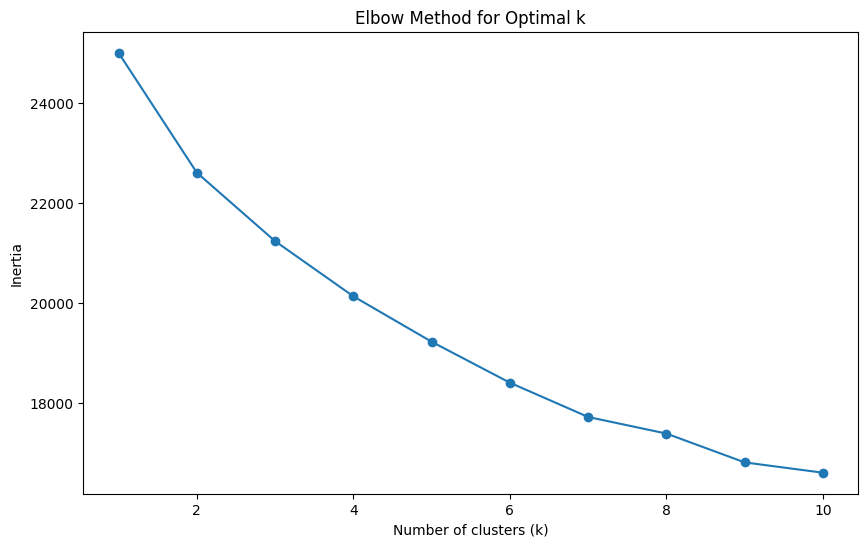

In [49]:
# Cluster Analysis to identify customer segments to see if we can identify any patterns among churners vs non-churners

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Select features for clustering (excluding CustomerID and ChurnStatus)
features = Customer_Data.select_dtypes(include='number').drop(columns=['CustomerID', 'ChurnStatus'])    
# Determine optimal number of clusters using Elbow Method
inertia = []    
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')    
plt.ylabel('Inertia')
plt.show()  

In [56]:
# Create combined unresolved interactions column
Customer_Data['TotalUnresolved'] = (Customer_Data['FeedbackUnresolved'] + 
                                     Customer_Data['ComplaintUnresolved'] + 
                                     Customer_Data['InquiryUnresolved'])

# Now run clustering and aggregate
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
Customer_Data['Cluster'] = kmeans.fit_predict(features)

cluster_summary = Customer_Data.groupby('Cluster').agg(
    Count = ('CustomerID', 'count'),
    Age = ('Age', 'mean'),
    TotalUnresolved = ('TotalUnresolved', 'mean'),
    TotalSpent = ('TotalSpent', 'mean'),
    TransactionFrequency = ('TransactionFrequency', 'mean'),
    LoyaltyLength = ('LoyaltyLength', 'mean'),
    LoginFrequency = ('LoginFrequency', 'mean'),
    ChurnRate = ('ChurnStatus', 'mean')
).reset_index()

display(cluster_summary)

,Cluster,Count,Age,TotalUnresolved,TotalSpent,TransactionFrequency,LoyaltyLength,LoginFrequency,ChurnRate
0,0,115,0.01,-0.50,0.22,0.25,0.26,-0.05,0.22
1,1,118,-0.07,-0.50,0.10,0.10,0.24,-0.04,0.19
2,2,108,-0.01,-0.41,-1.38,-1.28,-1.30,0.01,0.16
3,3,234,0.07,-1.23,0.32,0.41,0.45,-0.06,0.19
4,4,92,-0.16,1.79,0.32,0.23,0.30,0.11,0.24
5,5,79,-0.19,-0.31,-1.06,-1.43,-1.62,0.06,0.20
6,6,78,0.12,1.63,0.44,0.35,0.23,0.11,0.21
7,7,114,0.02,2.27,0.30,0.36,0.35,0.03,0.20
8,8,62,0.19,-1.23,0.36,0.41,0.31,-0.02,0.27


***Observations:***
Group 6 and 8 Churns at a 21% and 27% respectively.

***Why It Matters:***
These are number 1 and number 2 biggest spenders on average.  The reason they churn is undetermined because the features have such low correlation. Further investigation is required. 

In [51]:
# Compare the high-churn vs low-churn clusters
high_churn = Customer_Data[Customer_Data['Cluster'] == 3].mean()
low_churn = Customer_Data[Customer_Data['Cluster'] == 4].mean()

comparison = pd.DataFrame({
    'High Churn (Cluster 3)': high_churn.drop('CustomerID'),
    'Low Churn (Cluster 4)': low_churn.drop('CustomerID'),
    'Difference': high_churn - low_churn
}).round(2)

print(comparison.drop('CustomerID'))

                             High Churn (Cluster 3)  Low Churn (Cluster 4)  \
Age                                            0.07                  -0.16   
ChurnStatus                                    0.19                   0.24   
Cluster                                        3.00                   4.00   
ComplaintCount                                -0.61                   1.44   
ComplaintResolved                             -0.41                  -0.41   
ComplaintUnresolved                           -0.44                   2.29   
FeedbackCount                                 -0.62                   0.05   
FeedbackResolved                              -0.47                   0.17   
FeedbackUnresolved                            -0.41                  -0.11   
IncomeLevel                                    0.05                   0.16   
InquiryCount                                  -0.59                  -0.59   
InquiryResolved                               -0.42             